<a href="https://colab.research.google.com/github/rodrigossilveira/DS_projects/blob/main/Stocks_independence_by_itemset_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stock independence by itemset mining
 When investing a very important rule is  "Don't put all your eggs in the same basket", meaning one should diversify it's investments so the performance of some can offset the negative performance of others and protect the value of the portfolio. But diversification is not a trivial taks as many stocks tend to move together. Here this problem will be tackled trying to use itemset mining as a way to discovering wich stocks are connected/dependent. 

In [ ]:
import pandas as pd
display("Ready!")

'Ready!'

We will be using here historical data from B3, the company responsible for stock exchange here in Brazil. The data is available at [their website](https://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/historico/mercado-a-vista/cotacoes-historicas/) where there is also a [guide](https://drive.google.com/file/d/1gMkCG4HvlWokYN7c_NCGvSnULRhNzQNA/view?usp=sharing) to understanding the data layout. The dataset has three parts: The first line is the header and the last the trailer, both with some information about the year of the data, and it's source. The rest of the dataset is fixed width formatted, meaning that each column has a fixed interval in the dataset, with diferent sizes. The guide specifies the starting and ending character of each columns, as well as their names, and we are going to use it to get the data right. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#The starting points of each column and the ending point of the last one were written bellow
starting_points = [1,3,11,13,25,28,40,50,53,57,70,83,96,109,122,135,148,153,171,189,202,203,211,218,231,243,245]
width = []
#By subtracting each with the previous one we will obtain the columns intervals
for i in range(len(starting_points)-1):
  width.append(starting_points[i+1] - starting_points[i])
#That we can finally use to import the data
path = '/content/drive/MyDrive/Colab_Data/Stocks Independence/COTAHIST_A2020.TXT'
stocks_results = pd.read_fwf(path, widths=width, header = 0)
#The first and last line that read 99COTAHIST.2020BOVESPA 2020123000001251648
#were not considered in the dataframe
stocks_results.head(-5)

,00,COTAHIST,.2,020BOVESPA 2,020,1230,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,1,20200102,2.0,AALR3,10,ALLIAR,ON NM,NaN,R$,1829.0,1900.0,1828.0,1868.0,1900.0,1899.0,1901.0,2443.0,585800.0,1.094620e+09,0.0,0.0,99991231.0,1.0,0.0,BRAALRACNOR6,10.0
1,1,20200102,2.0,AAPL34,10,APPLE,DRN,NaN,R$,12000.0,12134.0,12000.0,12073.0,12134.0,10550.0,12134.0,9.0,12700.0,1.533380e+08,0.0,0.0,99991231.0,1.0,0.0,BRAAPLBDR004,13.0
2,1,20200102,2.0,ABCB4,10,ABC BRASIL,PN EJ N2,NaN,R$,2000.0,2030.0,1982.0,2005.0,2030.0,2008.0,2030.0,3979.0,870400.0,1.745788e+09,0.0,0.0,99991231.0,1.0,0.0,BRABCBACNPR4,13.0
3,1,20200102,2.0,ABEV3,10,AMBEV S/A,ON EJ,NaN,R$,1886.0,1925.0,1878.0,1912.0,1920.0,1919.0,1920.0,31581.0,16011300.0,3.062348e+10,0.0,0.0,99991231.0,1.0,0.0,BRABEVACNOR1,12.0
4,1,20200102,2.0,ADHM3,10,ADVANCED-DH,ON,NaN,R$,255.0,255.0,235.0,244.0,248.0,248.0,249.0,307.0,193400.0,4.719270e+07,0.0,0.0,99991231.0,1.0,0.0,BRADHMACNOR9,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251637,1,20201230,82.0,YDUQM290,80,YDUQE,ON NM,0.0,R$,18.0,18.0,18.0,18.0,18.0,5.0,33.0,1.0,100.0,1.800000e+03,2900.0,0.0,20210118.0,1.0,0.0,BRYDUQACNOR3,10.0
1251638,1,20201230,82.0,YDUQM310,80,YDUQE FM,ON NM,0.0,R$,49.0,49.0,49.0,49.0,49.0,47.0,0.0,2.0,2000.0,9.800000e+04,3100.0,0.0,20210118.0,1.0,0.0,BRYDUQACNOR3,10.0
1251639,1,20201230,82.0,YDUQM320,80,YDUQE FM,ON NM,0.0,R$,90.0,90.0,75.0,81.0,79.0,78.0,0.0,11.0,2200.0,1.786000e+05,3200.0,0.0,20210118.0,1.0,0.0,BRYDUQACNOR3,10.0
1251640,1,20201230,82.0,YDUQM330,80,YDUQE FM,ON NM,0.0,R$,115.0,127.0,115.0,116.0,127.0,0.0,150.0,6.0,8500.0,9.895000e+05,3300.0,0.0,20210118.0,1.0,0.0,BRYDUQACNOR3,10.0


In [ ]:
#Here we add the column names according to the data guide
column_names = ['Registry type', 'Session date','BDI code','Stock Symbol',
               'Market Type',  'Stock Issuing Company Name', 
                'Stock Specification', 'Prazo',  'Currency used',
                'Openning price', 'Maximum price', 'Minimal Price','Mean price',
                'Last exchange price', 'Best buying offer', 'Best selling offer',
                'Number of transactions', 'Number of stocks exchanged',
                'Volume of stocks exchanged', 'Price for options market', 
                'Price correction indicator', 'Due date', 'Quotation Factor',
                'Options price in points', 'Internal stock code',
                'Stock Distribuiton number']
stocks_results.columns = column_names

#Some columns came without the decimal separator, so we need to divide them by 100
decimal_columns = ['Openning price', 'Maximum price', 'Minimal Price',
                   'Mean price','Last exchange price', 'Best buying offer',
                   'Best selling offer','Volume of stocks exchanged', 
                   'Price for options market']
#Executing the division                   
for col in decimal_columns:
  stocks_results[col] = [i/100 for i in stocks_results[col]]
  
stocks_results.head(-1)                   

,Registry type,Session date,BDI code,Stock Symbol,Market Type,Stock Issuing Company Name,Stock Specification,Prazo,Currency used,Openning price,Maximum price,Minimal Price,Mean price,Last exchange price,Best buying offer,Best selling offer,Number of transactions,Number of stocks exchanged,Volume of stocks exchanged,Price for options market,Price correction indicator,Due date,Quotation Factor,Options price in points,Internal stock code,Stock Distribuiton number
0,1,20200102,2.0,AALR3,10,ALLIAR,ON NM,NaN,R$,18.29,19.00,18.28,18.68,19.00,18.99,19.01,2443.0,585800.0,10946196.0,0.0,0.0,99991231.0,1.0,0.0,BRAALRACNOR6,10.0
1,1,20200102,2.0,AAPL34,10,APPLE,DRN,NaN,R$,120.00,121.34,120.00,120.73,121.34,105.50,121.34,9.0,12700.0,1533380.0,0.0,0.0,99991231.0,1.0,0.0,BRAAPLBDR004,13.0
2,1,20200102,2.0,ABCB4,10,ABC BRASIL,PN EJ N2,NaN,R$,20.00,20.30,19.82,20.05,20.30,20.08,20.30,3979.0,870400.0,17457878.0,0.0,0.0,99991231.0,1.0,0.0,BRABCBACNPR4,13.0
3,1,20200102,2.0,ABEV3,10,AMBEV S/A,ON EJ,NaN,R$,18.86,19.25,18.78,19.12,19.20,19.19,19.20,31581.0,16011300.0,306234791.0,0.0,0.0,99991231.0,1.0,0.0,BRABEVACNOR1,12.0
4,1,20200102,2.0,ADHM3,10,ADVANCED-DH,ON,NaN,R$,2.55,2.55,2.35,2.44,2.48,2.48,2.49,307.0,193400.0,471927.0,0.0,0.0,99991231.0,1.0,0.0,BRADHMACNOR9,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251641,1,20201230,82.0,YDUQN320,80,YDUQE FM,ON NM,0.0,R$,2.00,2.00,2.00,2.00,2.00,0.00,0.00,1.0,100.0,200.0,32.0,0.0,20210222.0,1.0,0.0,BRYDUQACNOR3,10.0
1251642,1,20201230,82.0,YDUQN330,80,YDUQE FM,ON NM,0.0,R$,2.48,2.48,2.26,2.44,2.26,0.00,0.00,2.0,600.0,1466.0,33.0,0.0,20210222.0,1.0,0.0,BRYDUQACNOR3,10.0
1251643,1,20201230,82.0,YDUQM340,80,YDUQE FM,ON NM,0.0,R$,1.83,1.90,1.83,1.83,1.90,0.00,0.00,2.0,6400.0,11733.0,34.0,0.0,20210118.0,1.0,0.0,BRYDUQACNOR3,10.0
1251644,1,20201230,82.0,YDUQN340,80,YDUQE FM,ON NM,0.0,R$,2.91,2.91,2.86,2.90,2.86,0.00,0.00,5.0,7500.0,21750.0,34.0,0.0,20210222.0,1.0,0.0,BRYDUQACNOR3,10.0


In [ ]:
stocks_results[stocks_results['Session date'] == 'COTAHIST']

,Registry type,Session date,BDI code,Stock Symbol,Market Type,Stock Issuing Company Name,Stock Specification,Prazo,Currency used,Openning price,Maximum price,Minimal Price,Mean price,Last exchange price,Best buying offer,Best selling offer,Number of transactions,Number of stocks exchanged,Volume of stocks exchanged,Price for options market,Price correction indicator,Due date,Quotation Factor,Options price in points,Internal stock code,Stock Distribuiton number
1251646,99,COTAHIST,0.2,020BOVESPA 2,20,123000001251,648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
stocks_results = stocks_results.drop( index = 1251646, axis = 0 )
stocks_results[stocks_results['Session date'] == 'COTAHIST']

,Registry type,Session date,BDI code,Stock Symbol,Market Type,Stock Issuing Company Name,Stock Specification,Prazo,Currency used,Openning price,Maximum price,Minimal Price,Mean price,Last exchange price,Best buying offer,Best selling offer,Number of transactions,Number of stocks exchanged,Volume of stocks exchanged,Price for options market,Price correction indicator,Due date,Quotation Factor,Options price in points,Internal stock code,Stock Distribuiton number


In [ ]:
#We can see many different market types, some of them being them '10' for the  
#spot market and '70' and '80' for buy and sell options market respein that order
#here we are going to work just with spot market prices
stocks_results['Market Type'].unique()

array([10, 20, 17, 30, 70, 80, 12, 13])

In [ ]:
stocks_results.describe()

,Registry type,BDI code,Market Type,Prazo,Openning price,Maximum price,Minimal Price,Mean price,Last exchange price,Best buying offer,Best selling offer,Number of transactions,Number of stocks exchanged,Volume of stocks exchanged,Price for options market,Price correction indicator,Due date,Quotation Factor,Options price in points,Stock Distribuiton number
count,1251646.0,1.251646e+06,1.251646e+06,957142.000000,1.251646e+06,1.251646e+06,1.251646e+06,1.251646e+06,1.251646e+06,1.251646e+06,1.251646e+06,1.251646e+06,1.251646e+06,1.251646e+06,1.251646e+06,1251646.0,1.251646e+06,1.251646e+06,1.251646e+06,1.251646e+06
mean,1.0,6.766768e+01,5.511271e+01,10.804941,1.219686e+02,1.242004e+02,1.199222e+02,1.219918e+02,1.221121e+02,2.289504e+01,3.022806e+01,6.639222e+02,5.588722e+05,5.910125e+06,1.626257e+03,0.0,4.620748e+07,1.812516e+00,1.617410e+09,1.704489e+01
std,0.0,2.768218e+01,2.765531e+01,37.951177,2.024585e+03,2.029586e+03,2.020059e+03,2.024752e+03,2.024969e+03,2.381176e+02,2.209912e+03,4.061704e+03,1.936839e+07,8.565957e+07,1.250539e+04,0.0,3.739881e+07,2.847883e+01,1.255916e+10,1.244851e+01
min,1.0,2.000000e+00,1.000000e+01,0.000000,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.0,2.020012e+07,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.0,6.200000e+01,2.000000e+01,0.000000,4.500000e-01,5.000000e-01,4.000000e-01,4.500000e-01,4.500000e-01,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+03,1.863000e+03,0.000000e+00,0.0,2.020072e+07,1.000000e+00,0.000000e+00,1.000000e+01
50%,1.0,7.800000e+01,7.000000e+01,0.000000,2.070000e+00,2.220000e+00,1.970000e+00,2.080000e+00,2.090000e+00,5.000000e-02,9.000000e-02,7.000000e+00,7.500000e+03,1.656000e+04,1.682000e+01,0.0,2.020112e+07,1.000000e+00,0.000000e+00,1.300000e+01
75%,1.0,8.200000e+01,8.000000e+01,0.000000,1.400000e+01,1.425000e+01,1.377000e+01,1.400000e+01,1.400000e+01,1.860000e+00,2.340000e+00,4.000000e+01,5.000000e+04,1.429869e+05,3.185000e+01,0.0,9.999123e+07,1.000000e+00,0.000000e+00,1.900000e+01
max,1.0,9.600000e+01,8.000000e+01,999.000000,1.600000e+05,1.600000e+05,1.600000e+05,1.600000e+05,1.600000e+05,3.800000e+04,1.000000e+06,9.999800e+04,8.827189e+09,4.298380e+10,2.000000e+05,0.0,9.999123e+07,1.000000e+03,2.000000e+11,7.100000e+01


In [ ]:
stocks_results.describe(include = ['O'])

,Session date,Stock Symbol,Stock Issuing Company Name,Stock Specification,Currency used,Internal stock code
count,1251646,1251646,1251646,1251646,1251646,1251646
unique,249,75175,2147,190,1,1632
top,20201221,PETR4T,PETRE,ON NM,R$,BRPETRACNPR6
freq,7694,2356,62318,565204,1251646,106133


In [ ]:
stocks_results.isnull().sum()/stocks_results.shape[0]

Registry type                 0.000000
Session date                  0.000000
BDI code                      0.000000
Stock Symbol                  0.000000
Market Type                   0.000000
Stock Issuing Company Name    0.000000
Stock Specification           0.000000
Prazo                         0.235293
Currency used                 0.000000
Openning price                0.000000
Maximum price                 0.000000
Minimal Price                 0.000000
Mean price                    0.000000
Last exchange price           0.000000
Best buying offer             0.000000
Best selling offer            0.000000
Number of transactions        0.000000
Number of stocks exchanged    0.000000
Volume of stocks exchanged    0.000000
Price for options market      0.000000
Price correction indicator    0.000000
Due date                      0.000000
Quotation Factor              0.000000
Options price in points       0.000000
Internal stock code           0.000000
Stock Distribuiton number

In [ ]:
stocks_results.dtypes

Registry type                   int64
Session date                   object
BDI code                      float64
Stock Symbol                   object
Market Type                     int64
Stock Issuing Company Name     object
Stock Specification            object
Prazo                         float64
Currency used                  object
Openning price                float64
Maximum price                 float64
Minimal Price                 float64
Mean price                    float64
Last exchange price           float64
Best buying offer             float64
Best selling offer            float64
Number of transactions        float64
Number of stocks exchanged    float64
Volume of stocks exchanged    float64
Price for options market      float64
Price correction indicator    float64
Due date                      float64
Quotation Factor              float64
Options price in points       float64
Internal stock code            object
Stock Distribuiton number     float64
dtype: objec

In [ ]:
stocks_results['Number of transactions'].describe()

count    1.251646e+06
mean     6.639222e+02
std      4.061704e+03
min      1.000000e+00
25%      2.000000e+00
50%      7.000000e+00
75%      4.000000e+01
max      9.999800e+04
Name: Number of transactions, dtype: float64

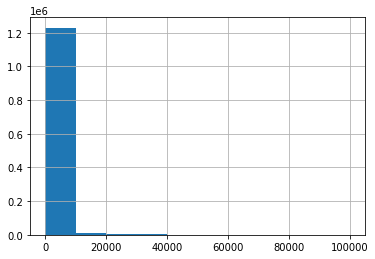

In [ ]:
stocks_results['Number of transactions'].hist()

In [ ]:
#Sorting the dataframe by day so every day can be transformed in five transactions
#Starting by getting the list of days the stock market opened
working_days = stocks_results['Session date'].unique()

this_day_transactions = stocks_results['Session date'] == '20201203'
stocks_results[this_day_transactions]

,Registry type,Session date,BDI code,Stock Symbol,Market Type,Stock Issuing Company Name,Stock Specification,Prazo,Currency used,Openning price,Maximum price,Minimal Price,Mean price,Last exchange price,Best buying offer,Best selling offer,Number of transactions,Number of stocks exchanged,Volume of stocks exchanged,Price for options market,Price correction indicator,Due date,Quotation Factor,Options price in points,Internal stock code,Stock Distribuiton number
266060,1,20201203,2.0,A1AP34,10,ADVANCE AUTO,DRN,NaN,R$,48.48,48.48,47.95,48.01,48.17,43.13,52.0,8.0,218.0,10467.21,0.00,0.0,99991231.0,1.0,0.0,BRA1APBDR001,10.0
266067,1,20201203,2.0,A1BB34,10,ABB LTD,DRN,NaN,R$,34.71,34.71,34.50,34.59,34.69,34.50,35.0,5.0,60.0,2075.81,0.00,0.0,99991231.0,1.0,0.0,BRA1BBBDR009,10.0
266072,1,20201203,2.0,A1BM34,10,ABIOMED INC,DRN,NaN,R$,344.20,344.20,344.20,344.20,344.20,282.14,0.0,1.0,25.0,8605.00,0.00,0.0,99991231.0,1.0,0.0,BRA1BMBDR006,10.0
266076,1,20201203,2.0,A1DM34,10,ARCHER DANIE,DRN,NaN,R$,259.14,259.14,256.30,257.72,256.30,0.00,0.0,2.0,2.0,515.44,0.00,0.0,99991231.0,1.0,0.0,BRA1DMBDR002,10.0
266082,1,20201203,2.0,A1EG34,10,AEGON NV,DRN,NaN,R$,19.36,19.36,19.36,19.36,19.36,31.97,0.0,1.0,1.0,19.36,0.00,0.0,99991231.0,1.0,0.0,BRA1EGBDR002,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164226,1,20201203,82.0,YDUQX340,80,YDUQE FM,ON NM,0.0,R$,0.71,0.71,0.71,0.71,0.71,0.00,0.0,1.0,100.0,71.00,33.99,0.0,20201221.0,1.0,0.0,BRYDUQACNOR3,10.0
1164227,1,20201203,82.0,YDUQX350,80,YDUQE FM,ON NM,0.0,R$,0.93,0.99,0.69,0.87,0.69,0.00,0.0,3.0,300.0,261.00,34.99,0.0,20201221.0,1.0,0.0,BRYDUQACNOR3,10.0
1164228,1,20201203,82.0,YDUQM350,80,YDUQE FM,ON NM,0.0,R$,1.66,1.66,1.48,1.57,1.48,0.00,0.0,2.0,3000.0,4710.00,35.00,0.0,20210118.0,1.0,0.0,BRYDUQACNOR3,10.0
1164229,1,20201203,82.0,YDUQX360,80,YDUQE FM,ON NM,0.0,R$,1.19,1.30,1.02,1.13,1.02,0.00,1.2,4.0,400.0,455.00,35.99,0.0,20201221.0,1.0,0.0,BRYDUQACNOR3,10.0


In [ ]:
stocks_results[stocks_results['Stock Symbol'] == 'BOVA11']

,Registry type,Session date,BDI code,Stock Symbol,Market Type,Stock Issuing Company Name,Stock Specification,Prazo,Currency used,Openning price,Maximum price,Minimal Price,Mean price,Last exchange price,Best buying offer,Best selling offer,Number of transactions,Number of stocks exchanged,Volume of stocks exchanged,Price for options market,Price correction indicator,Due date,Quotation Factor,Options price in points,Internal stock code,Stock Distribuiton number
579,1,20200102,14.0,BOVA11,10,ISHARES BOVA,CI,NaN,R$,112.45,114.24,112.13,113.41,114.24,114.24,114.27,44941.0,5684380.0,6.447048e+08,0.0,0.0,99991231.0,1.0,0.0,BRBOVACTF003,10.0
1356,1,20200103,14.0,BOVA11,10,ISHARES BOVA,CI,NaN,R$,112.93,114.50,112.80,113.67,113.80,113.79,113.80,41215.0,6602450.0,7.505251e+08,0.0,0.0,99991231.0,1.0,0.0,BRBOVACTF003,10.0
1357,1,20200106,14.0,BOVA11,10,ISHARES BOVA,CI,NaN,R$,113.00,113.45,112.02,112.69,112.59,112.50,112.59,49161.0,6771940.0,7.631702e+08,0.0,0.0,99991231.0,1.0,0.0,BRBOVACTF003,10.0
3971,1,20200107,14.0,BOVA11,10,ISHARES BOVA,CI,NaN,R$,112.90,112.90,111.59,112.15,112.24,112.24,112.50,82364.0,6096900.0,6.837988e+08,0.0,0.0,99991231.0,1.0,0.0,BRBOVACTF003,10.0
3972,1,20200108,14.0,BOVA11,10,ISHARES BOVA,CI,NaN,R$,112.65,113.10,111.40,112.09,111.95,111.90,111.95,46982.0,6472610.0,7.255592e+08,0.0,0.0,99991231.0,1.0,0.0,BRBOVACTF003,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286679,1,20201222,14.0,BOVA11,10,ISHARES BOVA,CI,NaN,R$,111.62,112.54,111.27,112.00,112.25,112.25,112.30,52234.0,5273026.0,5.905817e+08,0.0,0.0,99991231.0,1.0,0.0,BRBOVACTF003,10.0
286680,1,20201223,14.0,BOVA11,10,ISHARES BOVA,CI,NaN,R$,112.55,113.91,112.52,113.33,113.14,113.14,113.15,68933.0,4856930.0,5.504374e+08,0.0,0.0,99991231.0,1.0,0.0,BRBOVACTF003,10.0
286681,1,20201228,14.0,BOVA11,10,ISHARES BOVA,CI,NaN,R$,114.00,114.77,113.77,114.37,114.70,114.67,114.70,56995.0,5433712.0,6.214693e+08,0.0,0.0,99991231.0,1.0,0.0,BRBOVACTF003,10.0
286682,1,20201229,14.0,BOVA11,10,ISHARES BOVA,CI,NaN,R$,115.00,115.40,114.25,114.84,114.97,114.97,114.98,43775.0,4278894.0,4.914306e+08,0.0,0.0,99991231.0,1.0,0.0,BRBOVACTF003,10.0


In [ ]:
stocks_results[stocks_results['Session date']=='COTAHIST']


,Registry type,Session date,BDI code,Stock Symbol,Market Type,Stock Issuing Company Name,Stock Specification,Prazo,Currency used,Openning price,Maximum price,Minimal Price,Mean price,Last exchange price,Best buying offer,Best selling offer,Number of transactions,Number of stocks exchanged,Volume of stocks exchanged,Price for options market,Price correction indicator,Due date,Quotation Factor,Options price in points,Internal stock code,Stock Distribuiton number


In [ ]:
stocks_results = stocks_results[(stocks_results['Market Type'] == 10)+(stocks_results['Market Type'] == 17)+(stocks_results['Market Type'] == 20)]
#+(stocks_results['Market Type'] == 30)]
print('10: ' + str(sum((stocks_results['Market Type'] == 10))) + ' 17: ' + str(sum(stocks_results['Market Type'] == 17)) + ' 20: '+ str(sum(stocks_results['Market Type'] == 20)))

10: 187306 17: 43 20: 107155


/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [ ]:
len(stocks_results)

294504

In [ ]:
working_days = stocks_results['Session date'].unique()
stocks_symbols = stocks_results['Stock Symbol'].unique()
sorta_table = list(stocks_results['Stock Symbol'].unique())
sorta_table.insert(0, 'Transactions')
binary_table = [sorta_table]
daily_transactions = [0]*len(stocks_symbols)
for i in working_days: 

  this_day_transactions = stocks_results[stocks_results['Session date'] == i]
  daily_IBOVV = this_day_transactions[this_day_transactions['Stock Symbol'] == 'BOVA11']
  IBOVV_var = (daily_IBOVV['Last exchange price'] - daily_IBOVV['Openning price'])/daily_IBOVV['Openning price']
  for number in range(5):
    daily_transactions[number] = [0]*len(stocks_symbols)
    daily_transactions[number].insert(0,i + str(number + 1))

  this_day_stocks = this_day_transactions['Stock Symbol'].unique()


  for j in range(len(stocks_symbols)):
    if not(stocks_symbols[j] in this_day_stocks): continue
    stock = this_day_transactions[this_day_transactions['Stock Symbol'] == stocks_symbols[j]]
    stock_var = (stock['Last exchange price'] - stock['Openning price'])/stock['Openning price']
    stock_var = float(stock_var) - float(IBOVV_var)
    
    if stock_var>1.5:
      daily_transactions[0][j+1] = 1
    elif stock_var>0.005:
      daily_transactions[1][j+1] = 1
    elif stock_var>-0.005:
      daily_transactions[2][j+1] = 1     
    elif stock_var>-1.5:
      daily_transactions[3][j+1] = 1      
    if stock_var<=-1.5:
      daily_transactions[4][j+1] = 1

  for k in range(5):
    binary_table.append(daily_transactions[k])
 

In [ ]:
this_day_transactions

,Registry type,Session date,BDI code,Stock Symbol,Market Type,Stock Issuing Company Name,Stock Specification,Prazo,Currency used,Openning price,Maximum price,Minimal Price,Mean price,Last exchange price,Best buying offer,Best selling offer,Number of transactions,Number of stocks exchanged,Volume of stocks exchanged,Price for options market,Price correction indicator,Due date,Quotation Factor,Options price in points,Internal stock code,Stock Distribuiton number
285241,1,20201223,2.0,A1BB34,10,ABB LTD,DRN,NaN,R$,35.21,35.90,35.21,35.49,35.90,35.77,0.00,7.0,10.0,354.92,0.0,0.0,99991231.0,1.0,0.0,BRA1BBBDR009,10.0
285257,1,20201223,2.0,A1EE34,10,AMEREN CORP,DRN,NaN,R$,204.69,204.69,180.01,191.55,180.01,180.01,212.50,7.0,24.0,4597.33,0.0,0.0,99991231.0,1.0,0.0,BRA1EEBDR007,10.0
285262,1,20201223,2.0,A1EG34,10,AEGON NV,DRN,NaN,R$,19.09,19.90,19.09,19.60,19.71,19.18,19.90,43.0,215.0,4215.25,0.0,0.0,99991231.0,1.0,0.0,BRA1EGBDR002,10.0
285266,1,20201223,2.0,A1EN34,10,ALLIANT ENER,DRN,NaN,R$,271.29,271.29,261.50,264.32,262.31,246.67,295.96,4.0,4.0,1057.29,0.0,0.0,99991231.0,1.0,0.0,BRA1ENBDR008,10.0
285268,1,20201223,2.0,A1EP34,10,AMERICAN ELE,DRN,NaN,R$,212.28,212.52,210.99,212.07,210.99,183.84,245.00,3.0,30.0,6362.19,0.0,0.0,99991231.0,1.0,0.0,BRA1EPBDR003,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294475,1,20201223,2.0,YDUQ3,10,YDUQS PART,ON NM,NaN,R$,32.75,33.94,32.59,33.36,32.91,32.91,33.00,9851.0,2235900.0,74605008.00,0.0,0.0,99991231.0,1.0,0.0,BRYDUQACNOR3,10.0
294482,1,20201223,96.0,YDUQ3F,20,YDUQS PART,ON NM,NaN,R$,32.26,33.92,32.25,33.37,32.80,32.80,33.10,777.0,14765.0,492771.26,0.0,0.0,99991231.0,1.0,0.0,BRYDUQACNOR3,10.0
294492,1,20201223,2.0,Z1OM34,10,ZOOM VIDEO,DRN,NaN,R$,82.99,84.42,78.92,80.03,79.80,79.70,81.00,72.0,3369.0,269634.91,0.0,0.0,99991231.0,1.0,0.0,BRZ1OMBDR000,10.0
294498,1,20201223,2.0,Z1TO34,10,ZTO EXPRESS,DRN,NaN,R$,36.80,36.80,36.76,36.78,36.76,0.00,48.96,2.0,102.0,3751.60,0.0,0.0,99991231.0,1.0,0.0,BRZ1TOBDR005,10.0


In [ ]:
Transactions = pd.DataFrame(data = binary_table)
Transactions.head(-5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525,2526,2527,2528
0,Transactions,AALR3,AAPL34,ABCB4,ABEV3,ADHM3,AFLT3,AGRO3,ALPA3,ALPA4,ALSO3,ALUP3,ALUP4,ALUP11,AMAR3,AMZO34,ANIM3,APER3,ARZZ3,ATOM3,ATTB34,AZUL4,B3SA3,BABA34,BAHI3,BAUH4,BAZA3,BBAS3,BBDC3,BBDC4,BBRK3,BBSE3,BCSA34,BEEF3,BEES3,BEES4,BERK34,BGIP4,BIDI3,BIDI4,...,BIJR39,BILF39,BITO39,BIVB39,BIXJ39,BIXN39,BNRG3L,BUSM39,CEED1,O1DF34,R1EL34,RDSA35,A1UA34,AVLL3,AVLL3F,AVLL11,CEED1F,CEPE3F,CIAG6L,GOLD11,HCST11,IDVL3L,IDVL4L,M1UF34,MORE12,NGRD3,NGRD3F,RCRO5L,RDOR3,RDOR3F,VIGT12,HSLG11,HSRE11,I1QY34,LSXM35,RELG11,RZAK11,S1BS34,SLED12F,XINA11
1,202001021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,202001022,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,202001023,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,202001024,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,1,0,1,1,0,1,1,0,1,1,0,0,0,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236,202012301,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1237,202012302,1,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,0,1
1238,202012303,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1239,202012304,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
Transactions.to_csv("Transactions11_12.csv")
from google.colab import files
files.download("Transactions11_12.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%pip install mlxtend --upgrade
import pandas as pd
from mlxtend.frequent_patterns import fpgrowth

In [ ]:
df = pd.read_csv('/content/Transactions11_12.csv', header=1)
df.head(-5)

,0,Transactions,AALR3,AAPL34,ABCB4,ABEV3,ADHM3,AFLT3,AGRO3,ALPA3,ALPA4,ALSO3,ALUP3,ALUP4,ALUP11,AMAR3,AMZO34,ANIM3,APER3,ARZZ3,ATOM3,ATTB34,AZUL4,B3SA3,BABA34,BAHI3,BAUH4,BAZA3,BBAS3,BBDC3,BBDC4,BBRK3,BBSE3,BCSA34,BEEF3,BEES3,BEES4,BERK34,BGIP4,BIDI3,...,BIJR39,BILF39,BITO39,BIVB39,BIXJ39,BIXN39,BNRG3L,BUSM39,CEED1,O1DF34,R1EL34,RDSA35,A1UA34,AVLL3,AVLL3F,AVLL11,CEED1F,CEPE3F,CIAG6L,GOLD11,HCST11,IDVL3L,IDVL4L,M1UF34,MORE12,NGRD3,NGRD3F,RCRO5L,RDOR3,RDOR3F,VIGT12,HSLG11,HSRE11,I1QY34,LSXM35,RELG11,RZAK11,S1BS34,SLED12F,XINA11
0,1,202001021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,202001022,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,202001023,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,202001024,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,1,0,1,1,0,1,1,0,1,1,0,0,0,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,202001025,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,1236,202012301,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1236,1237,202012302,1,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,1,0,0,0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,0,1
1237,1238,202012303,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1238,1239,202012304,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
transactions = df.drop(columns='Transactions')
transactions = transactions.drop(columns = '0')
transactions

,AALR3,AAPL34,ABCB4,ABEV3,ADHM3,AFLT3,AGRO3,ALPA3,ALPA4,ALSO3,ALUP3,ALUP4,ALUP11,AMAR3,AMZO34,ANIM3,APER3,ARZZ3,ATOM3,ATTB34,AZUL4,B3SA3,BABA34,BAHI3,BAUH4,BAZA3,BBAS3,BBDC3,BBDC4,BBRK3,BBSE3,BCSA34,BEEF3,BEES3,BEES4,BERK34,BGIP4,BIDI3,BIDI4,BIDI11,...,BIJR39,BILF39,BITO39,BIVB39,BIXJ39,BIXN39,BNRG3L,BUSM39,CEED1,O1DF34,R1EL34,RDSA35,A1UA34,AVLL3,AVLL3F,AVLL11,CEED1F,CEPE3F,CIAG6L,GOLD11,HCST11,IDVL3L,IDVL4L,M1UF34,MORE12,NGRD3,NGRD3F,RCRO5L,RDOR3,RDOR3F,VIGT12,HSLG11,HSRE11,I1QY34,LSXM35,RELG11,RZAK11,S1BS34,SLED12F,XINA11
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,1,0,1,1,0,1,1,0,1,1,0,0,0,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1241,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1242,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1
1243,0,1,0,1,1,0,1,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,1,1,1,...,0,1,0,0,1,1,0,1,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0


In [ ]:
from mlxtend.frequent_patterns import fpgrowth
frequent_itemsets = fpgrowth(transactions, min_support=0.090, use_colnames=True)
frequent_itemsets.head(-5)

,support,itemsets
0,0.200000,(HSML11)
1,0.200000,(HGRU11)
2,0.200000,(HGLG11)
3,0.200000,(HGFF11)
4,0.200000,(HCRI11)
...,...,...
180811,0.090763,"(TORD11, PGCO34)"
180812,0.090763,"(TORD11, PFIN11)"
180813,0.090763,"(ITLC34, TORD11)"
180814,0.090763,"(VIGT11, TORD11)"


In [ ]:
from mlxtend.frequent_patterns import association_rules
rules =association_rules(frequent_itemsets, metric="lift", min_threshold=2)

In [ ]:
rules.head(-5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(IRDM11),(HSML11),0.200000,0.200000,0.119679,0.598394,2.991968,0.079679,1.992000
1,(HSML11),(IRDM11),0.200000,0.200000,0.119679,0.598394,2.991968,0.079679,1.992000
2,(HSML11),(KNHY11),0.200000,0.200000,0.119679,0.598394,2.991968,0.079679,1.992000
3,(KNHY11),(HSML11),0.200000,0.200000,0.119679,0.598394,2.991968,0.079679,1.992000
4,(HSML11),(JSRE11),0.200000,0.200000,0.115663,0.578313,2.891566,0.075663,1.897143
...,...,...,...,...,...,...,...,...,...
860414,(VRTA11),(TORD11),0.200000,0.141365,0.090763,0.453815,3.210227,0.062490,1.572059
860415,(TORD11),(VRTA11),0.141365,0.200000,0.090763,0.642045,3.210227,0.062490,2.234921
860416,(TORD11),(BNFS11),0.141365,0.200000,0.090763,0.642045,3.210227,0.062490,2.234921
860417,(BNFS11),(TORD11),0.200000,0.141365,0.090763,0.453815,3.210227,0.062490,1.572059


In [ ]:
frequent_itemsets.to_csv("frequent_itemsets11_12.csv")
from google.colab import files
files.download("frequent_itemsets11_12.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
rules.to_csv("assocition_rules11_12.csv")
from google.colab import files
files.download("assocition_rules11_12.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
transactions[column].iloc[2]

0

In [ ]:
transactions = df.drop(columns='Transactions')
transactions = transactions.drop(columns = '0')
transactions

,AALR3,AAPL34,ABCB4,ABEV3,ADHM3,AFLT3,AGRO3,ALPA3,ALPA4,ALSO3,ALUP3,ALUP4,ALUP11,AMAR3,AMZO34,ANIM3,APER3,ARZZ3,ATOM3,ATTB34,AZUL4,B3SA3,BABA34,BAHI3,BAUH4,BAZA3,BBAS3,BBDC3,BBDC4,BBRK3,BBSE3,BCSA34,BEEF3,BEES3,BEES4,BERK34,BGIP4,BIDI3,BIDI4,BIDI11,...,BIJR39,BILF39,BITO39,BIVB39,BIXJ39,BIXN39,BNRG3L,BUSM39,CEED1,O1DF34,R1EL34,RDSA35,A1UA34,AVLL3,AVLL3F,AVLL11,CEED1F,CEPE3F,CIAG6L,GOLD11,HCST11,IDVL3L,IDVL4L,M1UF34,MORE12,NGRD3,NGRD3F,RCRO5L,RDOR3,RDOR3F,VIGT12,HSLG11,HSRE11,I1QY34,LSXM35,RELG11,RZAK11,S1BS34,SLED12F,XINA11
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,1,0,1,1,0,1,1,0,1,1,0,0,0,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1241,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1242,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1
1243,0,1,0,1,1,0,1,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,1,1,1,...,0,1,0,0,1,1,0,1,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0


In [ ]:
lemonade_df = []
transitory_string = ''
for i in range(len(transactions)):
  #lemonade_df.append(transitory_list)
  transitory_string = ''
  for column in transactions.columns:
    if transactions[column].iloc[i] == 1:
      transitory_string = transitory_string + column + ' '
    #tansitory_sting = transitory_string + ','
  transitory_string = transitory_string[:-1]
  lemonade_df.append(transitory_string)

lemonade_df



In [ ]:
lemonade_df

In [ ]:
textfile = open("o_lemonade.txt", "w")
for element in lemonade_df:
    textfile.write(element + "\n")
textfile.close()


AttributeError: ignored

In [ ]:
files.download("o_lemonade.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
lemonade = pd.DataFrame(data = lemonade_df)
lemonade.head()

,0
0,
1,AALR3 ALUP11 APER3 B3SA3 BAUH4 BBDC3 BBDC4 BEE...
2,AAPL34 ABCB4 ABEV3 AMAR3 ATOM3 BBRK3 BIOM3 BNB...
3,ADHM3 AFLT3 AGRO3 ALPA3 ALPA4 ALSO3 ALUP3 ALUP...
4,


In [ ]:
transactions['AALR3'].iloc[0] == 1

False

In [ ]:
lemonade.to_csv("lemonade.csv")
from google.colab import files
files.download("lemonade.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
lemonade_df